In [436]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np

#https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

Define transformer and its components

In [437]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        #print('Q',Q.shape, Q)
        #print('WQ', self.W_q(Q).shape, self.W_q(Q) )
        #print(self.split_heads(self.W_q(Q)))
        
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [438]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [439]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length, setups):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros( max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        print('pos',position)
        
        pe[ :, 0::2] = torch.sin(position * div_term)
        pe[ :, 1::2] = torch.cos(position * div_term)
        

        pe=pe.transpose(0,1)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        #print('x', x.shape, x.size)
        #print('pe full',self.pe)
        #print('pe to add',self.pe[:, :, :x.size(2)])
        return x + self.pe[:, :, :x.size(2)]

In [440]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [441]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [442]:

class OnlyDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(OnlyDecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, tgt_mask):
        # print('x', x.shape, x)
        #print('mask', tgt_mask.shape, tgt_mask)
        attn_output = self.self_attn(x.transpose(1,2), x.transpose(1,2), x.transpose(1,2), tgt_mask)
        
        # print('atten',attn_output.shape, attn_output)
        x = self.norm1(x.transpose(1,2) + self.dropout(attn_output))
        
        # print('x',x.shape)
        ff_output = self.feed_forward(x)
        
        # print('ff', ff_output.shape, ff_output)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [443]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Encoder_Decoder_Transformer, self).__init__()
        print(type(src_vocab_size), type(d_model))
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [444]:
class Decoder_Transformer(nn.Module):
    def __init__(self, setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Decoder_Transformer, self).__init__()
        #self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length,setups)
        
        self.decoder_layers = nn.ModuleList([OnlyDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, 2)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        tgt_mask = (tgt != 0).unsqueeze(3)#.unsqueeze(1).unsqueeze(3)
        #print('target mask',tgt_mask.shape,tgt_mask)
        seq_length = tgt.size(2)
        nopeak_mask = (1 - torch.triu(torch.ones(1,2, seq_length, seq_length), diagonal=1)).bool()
        #print(nopeak_mask)
        #print('no peak mask',nopeak_mask.shape)
        
        tgt_mask = tgt_mask & nopeak_mask
        #print('mask',tgt_mask)
        return tgt_mask

    def forward(self, tgt):
        tgt_mask = self.generate_mask(tgt)
        #print("tgt",type(tgt),tgt)
        #print('pos enc', type(self.positional_encoding(tgt)), self.positional_encoding(tgt))
        tgt_embedded = self.dropout(self.positional_encoding(tgt))
        

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, tgt_mask)

        output = self.fc(dec_output)
        return output

Test Encoder Decoder Transformer

In [445]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data.csv",sep=',', header=0,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df.fillna(method='ffill', inplace=True)  # Forward fill NaNs


num_setups = 3
split_time = 0.6
train_data = df[df['time'] < split_time]  
test_data = df[df['time'] >= split_time]  

print(df.head())
print('train shape: ', train_data.shape)
print('test shape:  ', test_data.shape)

       time         u         x
0  0.000000  0.250000  1.000000
1  0.111111  0.264706  0.243464
2  0.222222  0.281250  0.362847
3  0.333333  0.300000  0.483333
4  0.444444  0.321429  0.605159
train shape:  (18, 3)
test shape:   (12, 3)


In [446]:
# Select position and control columns
train_array = train_data[['x', 'u']]
test_array = test_data[['x', 'u']]

# Reshape test and train arrays
train_array = train_array.to_numpy().reshape(num_setups, 2, train_array.shape[0]//num_setups) 
test_array = test_array.to_numpy().reshape(num_setups, 2, test_array.shape[0]//num_setups)

print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)

train shape:  (3, 2, 6)
test shape:   (3, 2, 4)


In [447]:
def create_sequences(data, sequence_length):
    inputs = []
    targets =[]
    pred_length = 1
    # for setup in data:
    #     print(len(setup) )
    #     inputs = []
    #     targets = []
    #     for i in range(len(setup) - sequence_length):
    #         inputs.append(data[i:i+sequence_length])
    #         targets.append(data[i+1:i+sequence_length+1,1]) #only u
            
    #     setup_inputs += [inputs]
    #     setup_targets += [targets]
        
    #     print(inputs)
    #     print(setup_inputs)
    # return np.array(setup_inputs), np.array(setup_targets)
    
    for setup in data:
        # print('setup',setup)
        # print('input', setup[:,:sequence_length-pred_length])
        # print('target', setup[:,sequence_length-pred_length:])
        inputs.append(setup[:,:sequence_length-pred_length])
        targets.append(setup[:,1:sequence_length]) # predict only u values

    return np.array(inputs), np.array(targets)

# Create sequences
x_train, y_train = create_sequences(train_array,train_array.shape[2])
x_test, y_test = create_sequences(test_array, test_array.shape[2])

print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)

x train shape:  (3, 2, 5)
y train shape:  (3, 2, 5)
x test shape:  (3, 2, 3)
y test shape:  (3, 2, 3)


In [448]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print('x train shape: ', x_train_tensor.shape)
print('y train shape: ', y_train_tensor.shape)
print('x test shape: ', x_test_tensor.shape)
print('y test shape: ', y_test_tensor.shape)

x train shape:  torch.Size([3, 2, 5])
y train shape:  torch.Size([3, 2, 5])
x test shape:  torch.Size([3, 2, 3])
y test shape:  torch.Size([3, 2, 3])


In [449]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [450]:
src_vocab_size = 10
tgt_vocab_size = 20
d_model = 2
num_heads = 2
num_layers = 1
d_ff = 15
max_seq_length = train_array.shape[2]
dropout = 0.1
setups = train_array.shape[0]
#batch_size = 64

transformer = Decoder_Transformer(setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

pos tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])


In [451]:

criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

early_stop_count = 0
min_val_loss = float('inf')
train_losses = []

for epoch in range(100):
    train_loss = 0
    
    for x, y in train_dataloader: #for each batch
        optimizer.zero_grad()
        #output = transformer(x, y[:, :-1]) #eclude last token from target
        output = transformer(x)
        y=y.transpose(1,2)
        # print('x', x.shape, x)
        # print('y', y.shape, y)
        # print('output',output.shape, output)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    if loss <= min_val_loss:
        min_val_loss = loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Avg Loss of batch: {train_loss}")
    if early_stop_count >= 20:
        print("Stopping: Loss increasing")
        break

Epoch: 1, Loss: 1.859786033630371, Avg Loss of batch: 1.6247945229212444
Epoch: 2, Loss: 1.6638214588165283, Avg Loss of batch: 1.557150959968567
Epoch: 3, Loss: 2.095736265182495, Avg Loss of batch: 1.5975205500920613
Epoch: 4, Loss: 1.6573784351348877, Avg Loss of batch: 1.5504048665364583
Epoch: 5, Loss: 1.7649257183074951, Avg Loss of batch: 1.5839524269104004
Epoch: 6, Loss: 2.0837562084198, Avg Loss of batch: 1.687933325767517
Epoch: 7, Loss: 2.0797388553619385, Avg Loss of batch: 1.6328777074813843
Epoch: 8, Loss: 1.644484281539917, Avg Loss of batch: 1.4426156282424927
Epoch: 9, Loss: 2.0718488693237305, Avg Loss of batch: 1.677099625269572
Epoch: 10, Loss: 2.067866802215576, Avg Loss of batch: 1.673503319422404
Epoch: 11, Loss: 2.0638651847839355, Avg Loss of batch: 1.668828288714091
Epoch: 12, Loss: 2.05985951423645, Avg Loss of batch: 1.6158273220062256
Epoch: 13, Loss: 2.055874824523926, Avg Loss of batch: 1.6626155773798625
Epoch: 14, Loss: 2.0518736839294434, Avg Loss of 

Epoch: 20, Loss: 1.606266736984253, Avg Loss of batch: 1.4692742427190144
Epoch: 21, Loss: 1.2920256853103638, Avg Loss of batch: 1.3899983962376912
Epoch: 22, Loss: 2.0208606719970703, Avg Loss of batch: 1.6307835976282756
Epoch: 23, Loss: 1.59711492061615, Avg Loss of batch: 1.4602049191792805
Epoch: 24, Loss: 1.7842575311660767, Avg Loss of batch: 1.5475990772247314
Epoch: 25, Loss: 2.009535789489746, Avg Loss of batch: 1.6205292145411174
Epoch: 26, Loss: 2.0057263374328613, Avg Loss of batch: 1.5694001118342082
Epoch: 27, Loss: 2.0018932819366455, Avg Loss of batch: 1.613614519437154
Epoch: 28, Loss: 1.9980690479278564, Avg Loss of batch: 1.583788235982259
Epoch: 29, Loss: 1.9942182302474976, Avg Loss of batch: 1.606663664182027
Epoch: 30, Loss: 1.765080213546753, Avg Loss of batch: 1.5280758142471313
Epoch: 31, Loss: 1.9865299463272095, Avg Loss of batch: 1.5529760519663494
Epoch: 32, Loss: 1.9827468395233154, Avg Loss of batch: 1.575587550799052
Epoch: 33, Loss: 1.978944778442382

In [462]:

transformer.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_losses=[]
val_outputs = []
with torch.no_grad():
    test_loss=0
    for x, y in test_dataloader:
        val_output = transformer(x)
        val_y=y.transpose(1,2)
        
        loss = criterion(val_output, val_y)
        print(f"Validation Loss: {loss.item()}")
        
        test_loss += loss.item()
        val_outputs.append(val_y)
    
    test_loss /= len(test_dataloader) #mean loss of batch
    test_losses.append(test_loss)
print('Avg loss: ', test_losses)
print('Predicitons: ', val_outputs)

Validation Loss: 1.7354358434677124
Validation Loss: 2.295659065246582
Validation Loss: 5.0055694580078125
Avg loss:  [3.0122214555740356]
Predicitons:  [tensor([[[0.3750, 0.4500],
         [0.9823, 1.2500],
         [0.4091, 0.5000]]]), tensor([[[0.6667, 0.8889],
         [0.9346, 1.3333],
         [0.7778, 1.0000]]]), tensor([[[1.3333, 1.7778],
         [1.4051, 2.3333],
         [1.5556, 2.0000]]])]


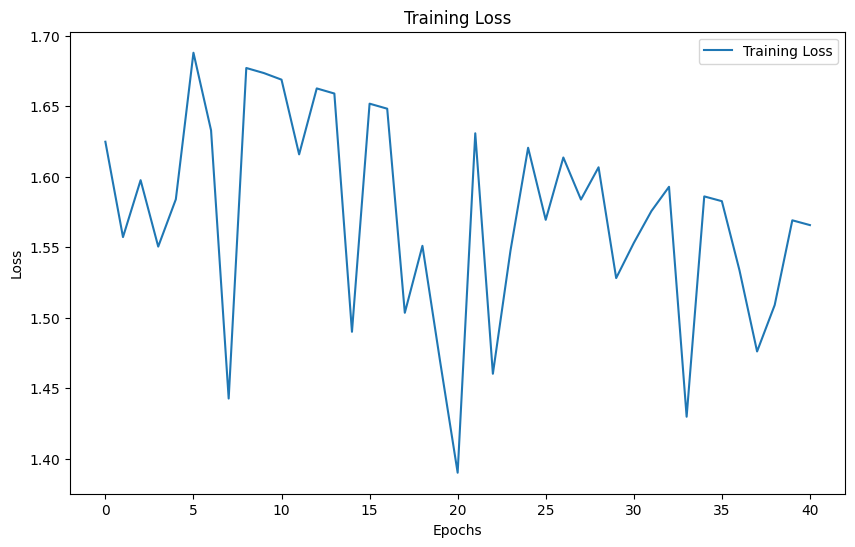

In [502]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [506]:
from sklearn.metrics import mean_squared_error, r2_score

def plot_predictions_vs_actual(predictions, actual, title='Predictions vs Actual'):
    plt.figure(figsize=(10, 6))

    val=""
    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        plt.plot(actual[i], '-x',label=f'Actual Values {val}')
        plt.plot(predictions[i],'-o', label=f'Predicted Values {val}')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    

def rmse_r2(predictions, actual, description ):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    r_squared = r2_score(actual, predictions)

    print(f'{description} Test RMSE: {rmse}')
    print(f'{description} Test R²: {r_squared}')
    

Function 1 Test RMSE: 0.0
Function 1 Test R²: 1.0


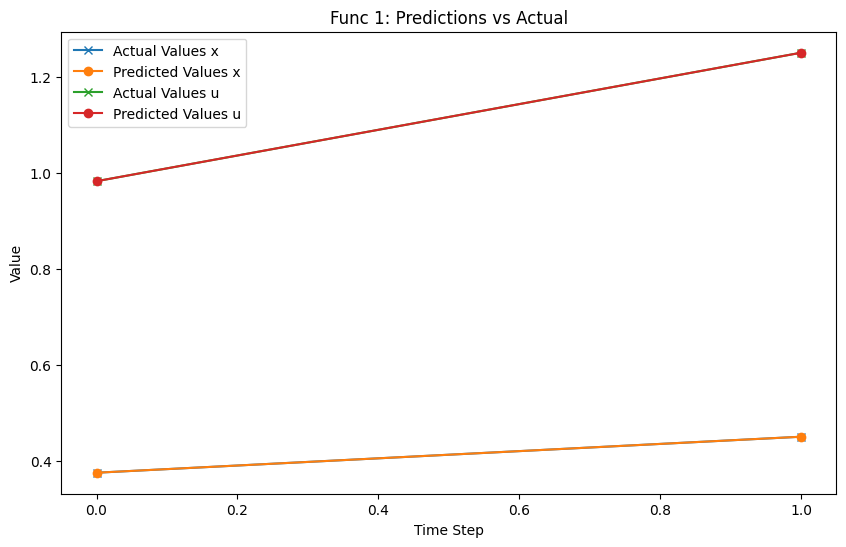

In [507]:
#Metrics function 1

rmse_r2(val_outputs[0].squeeze(0),y_test_tensor.transpose(1,2)[0,:,:], 'Function 1')
plot_predictions_vs_actual(val_outputs[0].squeeze(0),y_test_tensor.transpose(1,2)[0,:,:], 'Func 1: Predictions vs Actual')



torch.Size([3, 2])
tensor([[0.6667, 0.8889],
        [0.9346, 1.3333],
        [0.7778, 1.0000]])


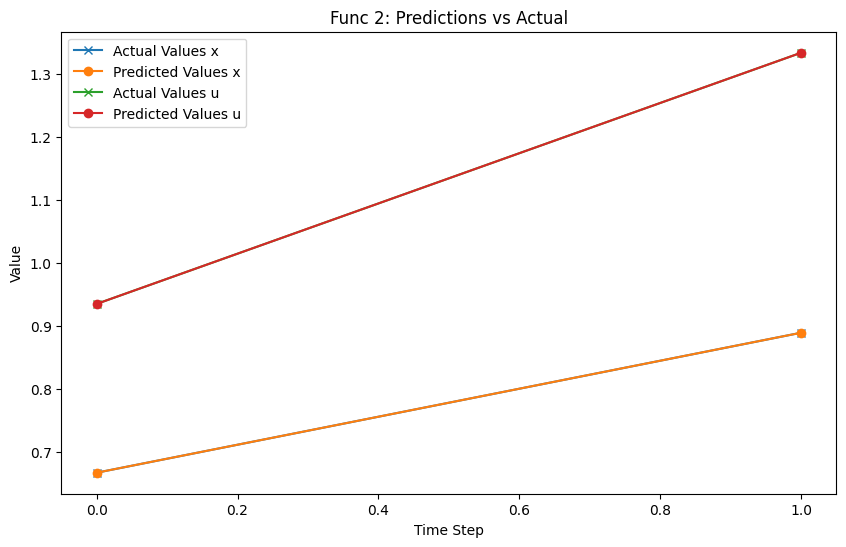

In [500]:
#Metrics function 2

rmse_r2(val_outputs[1].squeeze(0),y_test_tensor.transpose(1,2)[1,:,:], 'Function 2')
plot_predictions_vs_actual(val_outputs[1].squeeze(0),y_test_tensor.transpose(1,2)[1,:,:], 'Func 2: Predictions vs Actual')

torch.Size([3, 2])
tensor([[1.3333, 1.7778],
        [1.4051, 2.3333],
        [1.5556, 2.0000]])


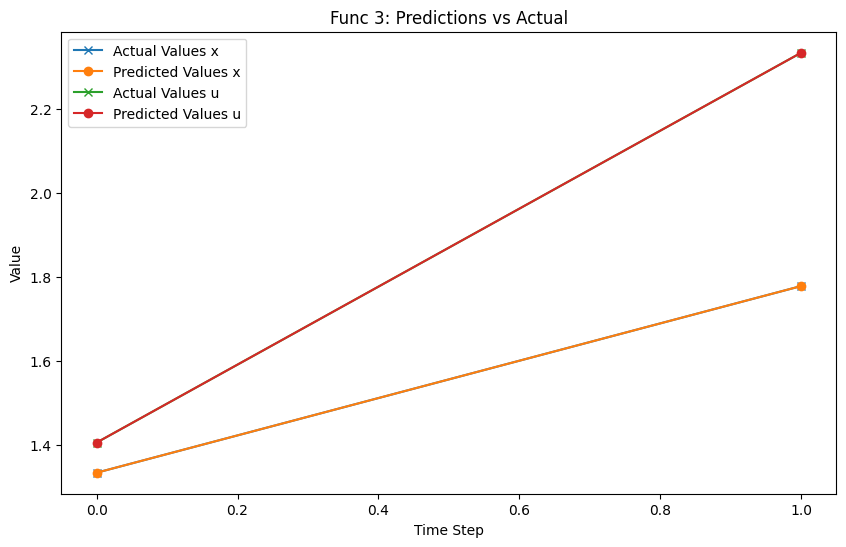

In [501]:
plot_predictions_vs_actual(val_outputs[2].squeeze(0),y_test_tensor.transpose(1,2)[2,:,:], 'Func 3: Predictions vs Actual') #plot for x